# Phasor Plot Analysis for Lifetime Unmixing

In [1]:
import napari
import tifffile
import numpy as np
import dask.array as da
from pathlib import Path
from napari.utils import nbscreenshot
from sklearn.cluster import KMeans

from napari_flim_phasor_plotter.filters import apply_binning
from napari_flim_phasor_plotter._reader import read_stack
from napari_flim_phasor_plotter._widget import make_flim_phasor_plot, split_n_largest_cluster_labels

from utilities import format_metadata, set_plot_zoom_position
import warnings
warnings.filterwarnings("ignore")

%load_ext watermark

## Inputs
### Input data paths

Additional metadata in case xml file is missing

In [2]:
z_pixel_size = 0.5*1e-6 # in m
pixel_size_unit = 'm'
time_resolution_per_slice = 0.663 # in seconds
time_unit = 's'
channel_names = ['Gut Autofluorescence', 'Germline Cells']

Plotting related inputs

In [3]:
# Number of bins in 2D histogram
bins = 400

# Axis limits for 2D histogram
x_lim = (-0.05, 1.05)
y_lim = (0.0, 0.55)

timelapse_flag = False

Phasor generation related inputs

In [4]:
# Manual threshold value for phasor plot
threshold = 15

# Median filter iteration number
median_filter_iteration = 3

# Harmonic number
harmonic = 3

# Binning settings
binning = False
binning_kernel_size = 3
binning_3D = False

Post-processing related inputs

In [5]:
clustering_method = 'KMeans'
n_clusters = 2
n_iter = 300

Sample related inputs

In [6]:
folder_data_path = Path("/home/pol_haase/mazo260d/Data/I227_Lifetime_Unmixing_of_Dyes_with_Overlapping_Sprectra/worm_data/JJ1473_sptw") # analyze channel 0

Create Output directories

In [7]:
sample_name = folder_data_path.stem
xml_path = None
# Create output folders
output_path = Path(folder_data_path) / 'Outputs'
output_path.mkdir(exist_ok=True)
segmentation_output_path = output_path / 'Segmentation'
segmentation_output_path.mkdir(exist_ok=True)
phasor_plots_output_path = output_path / 'Phasor Plots'
phasor_plots_output_path.mkdir(exist_ok=True)
screenshots_output_path = output_path / 'Screenshots'
screenshots_output_path.mkdir(exist_ok=True)
omero_output_path = output_path / 'OME-TIFFs'
omero_output_path.mkdir(exist_ok=True)


Get data and metadata paths

In [8]:
for file in folder_data_path.iterdir():
    # Read the zarr and a xml file
    if file.suffix == '.zarr':
        zarr_data_path = file
    if file.suffix == '.xml':
        xml_path = file

Read data and metadata

In [9]:
# Read the zarr file
data, flim_metadata = read_stack(zarr_data_path)
summed_intensity_stack = da.sum(data, axis=1).astype(np.uint32)
print("Extracting metadata...")
if xml_path is None:
    print("No xml file found. Using additional metadata.")
else:
    if not xml_path.exists():
        print("The xml file does not exist. Using additional metadata.")
    else:
        print(f"Reading metadata from: {xml_path} and zarr file.")
# Extract metadata
metadata_timelapse, metadata_single_timepoint = format_metadata(
    flim_metadata,
    xml_path, 
    data.shape,
    z_pixel_size,
    pixel_size_unit,
    time_resolution_per_slice,
    time_unit,
    channel_names,
    'CTZYX',
    timelapse_flag)

laser_frequency = flim_metadata[0]['frequency']/1e6 # in MHz
print(f'Laser frequency: {laser_frequency} MHz')
# Split channels
image_raw_FLIM_channel_0 = data[0] # first channel
image_raw_FLIM_channel_1 = data[1] # second channel

stack = True 
data type:  .zarr 
data_shape =  (2, 270, 1, 82, 128, 512) 

Extracting metadata...
Reading metadata from: /home/pol_haase/mazo260d/Data/I227_Lifetime_Unmixing_of_Dyes_with_Overlapping_Sprectra/worm_data/JJ1473_sptw/JJ1473.xml and zarr file.
Laser frequency: 39.01 MHz


In [10]:
summed_intensity_stack.shape

(2, 1, 82, 128, 512)

Write ome-tif file

In [11]:
output_file_name =  sample_name + f'.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(data[:,:,0], metadata=metadata_single_timepoint, compression='zlib')

Get channel to be phasor analyzed

In [12]:
image_raw_FLIM_channel_0 = np.asarray(image_raw_FLIM_channel_0)

Optionally apply binning

In [13]:
# Apply binning (if True)
if binning:
    image_raw_FLIM_channel_0 = apply_binning(image_raw_FLIM_channel_0,
                                                    bin_size=binning_kernel_size,
                                                    binning_3D=binning_3D)

Generate intensity image from raw FLIM image

In [14]:
image_intensity_channel_0 = np.sum(image_raw_FLIM_channel_0, axis=0)
image_intensity_channel_1 = np.sum(image_raw_FLIM_channel_1, axis=0)

print(f"{sample_name} max intensity: {image_intensity_channel_0.max()}")
print(f"{sample_name} average intensity: {image_intensity_channel_0.mean()}")

JJ1473_sptw max intensity: 306
JJ1473_sptw average intensity: 3.112902943680926


Save summed intensity image

In [15]:
output_file_name =  sample_name + f'_summed_intensity.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(summed_intensity_stack, metadata=metadata_timelapse, compression='zlib')

Add images to viewer

In [16]:
# Add images to napari viewer
viewer = napari.Viewer()
viewer.add_image(image_raw_FLIM_channel_0, name=(sample_name + ' raw channel 0'), blending='additive', colormap='cyan')
viewer.add_image(image_intensity_channel_0, name=(sample_name + ' intensity channel 0'), colormap='cyan')
viewer.add_image(image_intensity_channel_1, name=(sample_name + ' intensity channel 1'), colormap='magenta', blending='additive')

# Adjust viewer visualization (3D display, first microtime)
viewer.dims.ndisplay = 3
viewer.dims.current_step = (0, 0, 10, 128, 128)

Assistant skips harvesting pyclesperanto as it's not installed.


Generate phasor plot

In [19]:
plot_maker_widget = make_flim_phasor_plot()
# Generate phasor plot
phasor_plot_widget, labels_layer = plot_maker_widget(image_layer = viewer.layers[(sample_name + ' raw channel 0')],
                        laser_frequency = laser_frequency,
                        harmonic = harmonic,
                        threshold = threshold,
                        apply_median = True,
                        median_n = median_filter_iteration,
                        napari_viewer = viewer)

 Optimize phasor visualization and phasor plot position

In [20]:
phasor_plot_widget.bin_auto.setChecked(False)
phasor_plot_widget.bin_number_spinner.setValue(bins)
phasor_plot_widget.bin_number_set.clicked.emit(True)
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

Save screenshots and phasor plot

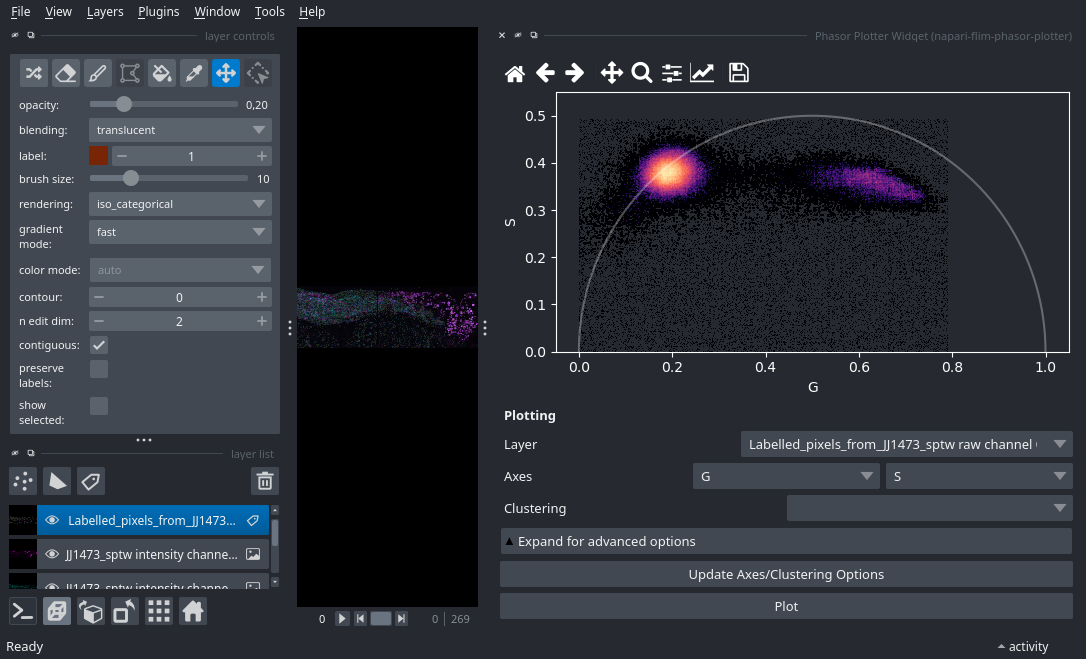

In [21]:
nbscreenshot(viewer)

In [22]:
# Save screenshot
screenshot = viewer.screenshot(canvas_only=False)
tifffile.imwrite(screenshots_output_path / f"{sample_name}_screenshot.png", screenshot)

# Save phasor plot before clustering
phasor_plot_widget.graphics_widget.axes.figure.savefig(phasor_plots_output_path / f'{sample_name}_phasor_plot.png', dpi=300)

Get labels layer with labelled pixels (labels)

In [23]:
for choice in phasor_plot_widget.layer_select.choices:
    if choice.name.startswith('Labelled_pixels_from_'):
        viewer.layers.selection.active = choice
        break

Get features table

In [24]:
features_table = labels_layer.features
features_table

,label,G,S,pixel_x_coordinates,pixel_y_coordinates,pixel_z_coordinates,frame
0,1,0.633930,0.364913,475,31,0,0
1,2,0.631062,0.359686,476,31,0,0
2,3,0.521094,0.359686,477,31,0,0
3,4,0.532609,0.317127,498,31,0,0
4,5,0.618280,0.332214,499,31,0,0
...,...,...,...,...,...,...,...
157401,157402,0.568711,0.336788,127,38,80,0
157402,157403,0.788080,0.275491,185,38,80,0
157403,157404,0.603035,0.349047,42,21,81,0
157404,157405,0.534453,0.349913,140,24,81,0


Cluster with KMeans

In [25]:
clustering_kmeans = KMeans(n_clusters=n_clusters, max_iter=n_iter)
kmeans_predictions = clustering_kmeans.fit_predict(features_table[['G', 'S']])
clustering_id = "KMEANS_CLUSTER_ID"

In [26]:
features_table[clustering_id] = kmeans_predictions
features_table

,label,G,S,pixel_x_coordinates,pixel_y_coordinates,pixel_z_coordinates,frame,KMEANS_CLUSTER_ID
0,1,0.633930,0.364913,475,31,0,0,1
1,2,0.631062,0.359686,476,31,0,0,1
2,3,0.521094,0.359686,477,31,0,0,1
3,4,0.532609,0.317127,498,31,0,0,1
4,5,0.618280,0.332214,499,31,0,0,1
...,...,...,...,...,...,...,...,...
157401,157402,0.568711,0.336788,127,38,80,0,1
157402,157403,0.788080,0.275491,185,38,80,0,1
157403,157404,0.603035,0.349047,42,21,81,0,1
157404,157405,0.534453,0.349913,140,24,81,0,1


### Update features table in layer

In [27]:
labels_layer.features = features_table
phasor_plot_widget.update_axes_and_clustering_id_lists()
phasor_plot_widget.plot_cluster_id.setCurrentText(clustering_id)

### Display KMeans predictions

In [28]:
phasor_plot_widget.run(
    labels_layer.features,
    phasor_plot_widget.plot_x_axis.currentText(),
    phasor_plot_widget.plot_y_axis.currentText(),
    phasor_plot_widget.plot_cluster_id.currentText(),
)
set_plot_zoom_position(phasor_plot_widget, x_lim, y_lim)

In [29]:
clusters_labels_layer = phasor_plot_widget.visualized_layer

### Save phasor plot after cluster selection

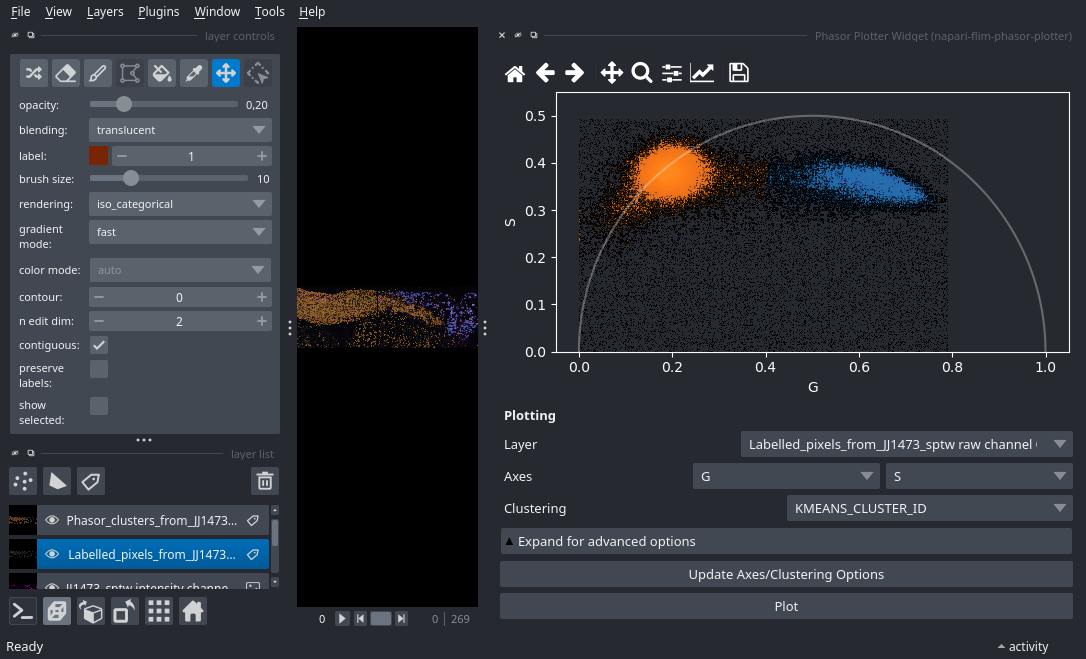

In [30]:
nbscreenshot(viewer)

In [31]:
phasor_plot_widget.graphics_widget.axes.figure.savefig(phasor_plots_output_path / f'{sample_name}_phasor_plot_after_cluster_selection.png', dpi=300)

### Save clusters masks

In [32]:
clusters_masks = clusters_labels_layer.data.astype(np.uint8)

# save segmentation results with tifffile
tifffile.imsave(segmentation_output_path / f'{sample_name}_cluster_masks.tiff', 
                clusters_masks, imagej=True)

### Split masks

In [33]:
list_of_labels_layers = split_n_largest_cluster_labels(
    labels_layer=labels_layer,
    clusters_labels_layer=clusters_labels_layer,
    clustering_id=clustering_id,
    n=n_clusters,
)

cluster_mask_image_0 = list_of_labels_layers[0].data
cluster_mask_image_1 = list_of_labels_layers[1].data

### Mask summed intensity

In [34]:
image_intensity_channel_0 = np.squeeze(image_intensity_channel_0)

In [35]:
image_intensity_channel_0_masked_0 = np.zeros_like(image_intensity_channel_0)
image_intensity_channel_0_masked_0[cluster_mask_image_0 > 0] = image_intensity_channel_0[cluster_mask_image_0 > 0]

image_intensity_channel_0_masked_1 = np.zeros_like(image_intensity_channel_0)
image_intensity_channel_0_masked_1[cluster_mask_image_1 > 0] = image_intensity_channel_0[cluster_mask_image_1 > 0]


### Build stack with pseudo-channels

In [36]:
data_channel_split = np.stack([image_intensity_channel_0_masked_0, image_intensity_channel_0_masked_1, np.squeeze(image_intensity_channel_1)])
data_channel_split = data_channel_split[:, None]
data_channel_split.shape

(3, 1, 82, 128, 512)

Format metadata for pseudo-channels

In [37]:
metadata_timelapse['Channel']['Name'] = ['HyD X 2 - Cluster 0', 'HyD X 2 - Cluster 1', 'HyD X 4']
metadata_timelapse['Channel']['EmissionWavelength'].insert(0, metadata_timelapse['Channel']['EmissionWavelength'][0])
metadata_timelapse['Channel']['EmissionWavelengthUnit'].insert(0, metadata_timelapse['Channel']['EmissionWavelengthUnit'][0])
metadata_timelapse['Channel']['ExcitationWavelength'].insert(0, metadata_timelapse['Channel']['ExcitationWavelength'][0])
metadata_timelapse['Channel']['ExcitationWavelengthUnit'].insert(0, metadata_timelapse['Channel']['ExcitationWavelengthUnit'][0])
metadata_timelapse

{'axes': 'CTZYX',
 'PhysicalSizeX': 0.54,
 'PhysicalSizeXUnit': 'µm',
 'PhysicalSizeY': 0.54,
 'PhysicalSizeYUnit': 'µm',
 'PhysicalSizeZ': 0.5,
 'PhysicalSizeZUnit': 'µm',
 'AcquisitionDate': '23/02/22 1:08:04.897 PM',
 'Channel': {'Name': ['HyD X 2 - Cluster 0', 'HyD X 2 - Cluster 1', 'HyD X 4'],
  'EmissionWavelength': [530.0, 530.0, 704.9999985],
  'EmissionWavelengthUnit': ['nm', 'nm', 'nm'],
  'ExcitationWavelength': [480.0, 480.0, 590.0],
  'ExcitationWavelengthUnit': ['nm', 'nm', 'nm']}}

Save stack with pseudo-channels (channel 0 split)

In [38]:
output_file_name =  sample_name + f'_summed_intensity_channel_split.ome.tif'
with tifffile.TiffWriter(omero_output_path / output_file_name, ome=True) as tif:
    tif.write(data_channel_split.astype(np.uint32), metadata=metadata_timelapse, compression='zlib')

Save table of phasors

In [39]:
features_table.to_csv(phasor_plots_output_path / f'{sample_name}_phasors_table.csv', index=False)

Save config file

In [40]:
file_path = output_path / f'{sample_name}_config.txt'

# Writing to the file
with open(file_path, 'w') as file:
    file.write(f"sample_name = {sample_name}\n")
    file.write(f"clustering_method = {clustering_method}\n")
    file.write(f"number of clusters = {n_clusters}\n")
    file.write(f"number of iterations of clustering method = {n_iter}\n")
    file.write(f"bins = {bins}\n")
    file.write(f"x_lim = {x_lim}\n")
    file.write(f"y_lim = {y_lim}\n")
    file.write(f"threshold = {threshold}\n")
    file.write(f"median_filter_iteration = {median_filter_iteration}\n")
    file.write(f"harmonic = {harmonic}\n")
    file.write(f"binning = {binning}\n")
    file.write(f"binning_kernel_size = {binning_kernel_size}\n")
    file.write(f"binning_3D = {binning_3D}\n")

## Packages Versions and Machine Info

In [41]:
%watermark -v -m --gpu -p napari,numpy,napari_flim_phasor_plotter,tifffile,pandas,skimage,sklearn,dask

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.18.1

napari                    : 0.5.5
numpy                     : 1.23.5
napari_flim_phasor_plotter: 0.1.2
tifffile                  : 2022.8.12
pandas                    : 2.2.3
skimage                   : 0.24.0
sklearn                   : 1.6.0
dask                      : 2024.8.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 5.15.0-25-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

GPU Info: 
  GPU 0: NVIDIA RTX 6000 Ada Generation
  GPU 1: NVIDIA RTX 6000 Ada Generation

